# MULTI-LABEL CLASSIFICATION

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score,make_scorer,hamming_loss
import sklearn

from skmultilearn.problem_transform import ClassifierChain

Now we have to read the right file:

In [2]:
profiles = pd.read_csv('DATA/driving_profiles_cleared_MULTI_LABEL_18_1.csv')
profiles.head()

,monitoring_start_month,monitoring_days,active_days,data_quality_score,reliability_score,car_use_score,driver_behavior_score,n_trips,fuel_costs,body_type,...,average_pause_time,max_pause_time,median_pause_time,percentage_start_home,percentage_start_office,average_trip_duration_sec,percentage_charger_nearby,percentage_charger_fast_nearby,percentage_charger_3F_nearby,ev_brands
0,7,31,30,9.373888,4.692516,7.451583,6.467989,392,16625,VAN,...,5591.336735,133880,557.5,7.397959,4.591837,1098.109694,13.520408,5.867347,7.653061,[]
1,6,30,27,9.062229,6.138472,7.616548,5.732751,314,17664,VAN,...,6739.085987,147051,703.0,8.280255,0.318471,1308.401274,13.057325,6.687898,6.369427,[]
2,5,31,26,8.950726,5.415178,7.771661,6.493076,249,11769,VAN,...,9403.775100,224802,606.0,9.638554,0.000000,1075.341365,13.654618,5.622490,8.032129,[]
3,3,92,78,9.003805,5.945673,7.027738,5.758369,789,17323,VAN,...,8688.593156,244481,606.0,9.632446,0.000000,1317.195184,14.575412,7.984791,6.590621,[]
4,4,30,25,8.851813,5.518089,6.905178,5.513861,266,19741,VAN,...,8229.680451,238754,552.0,9.022556,0.000000,1374.330827,14.661654,8.646617,6.015038,[]


Transforming the column `ev_brands` to list type

In [3]:
from ast import literal_eval

profiles.ev_brands = profiles.ev_brands.apply(literal_eval)

Next up we have to transform the column of `ev_brands` to a list of items of 0 or 1, where each index position defines a different car brand:

In [4]:
max_length = 0
max_brands = []
for recom in profiles.ev_brands: #iterating every profile
    if len(recom) > max_length:
        max_length = len(recom)
        max_brands = recom
        
max_brands

['Nissan',
 'Peugeot',
 'Hyundai',
 'Renault',
 'Skoda',
 'Honda',
 'Mazda',
 'Volkswagen',
 'DS',
 'BMW',
 'Smart',
 'Kia',
 'Mini',
 'Citroen',
 'Tesla',
 'Opel']

We found that there are 16 different brands for the EV cars. That means we create lists of 16 items for each profile where each item corresponds to a specific brand according to the above list

In [5]:
all_encoded_brands = []
for recom in profiles.ev_brands: #iterating every profile
    profile_brands = [0 for i in range(16)]
    for brand in recom: #iterating through every brand
        index_brand = max_brands.index(brand) #finding the index of the particular brand from the max_brands
        profile_brands[index_brand] = 1
    all_encoded_brands.append(np.asarray(profile_brands))
target = np.array([item for item in all_encoded_brands]) 
profiles = profiles.drop(['ev_brands'], axis=1) #deleting column from data

Next up, we have to create dummie variables for all the columns that have non continious numeric values:

In [6]:
profiles = pd.get_dummies(profiles, columns=['driver_name','body_type','monitoring_start_month'])

Here we can see the new shape of the data, 797 rows and 347 columns:

In [7]:
profiles.shape

(934, 157)

Fixing column names for lightGBM:

In [8]:
import re
profiles = profiles.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #fix error lgb does not support json characters

### ML Preprocessing

Now we shuffle the data and separate the column we want to predict afterwards:

profiles = profiles.sample(frac = 1, random_state=9) #shuffling data
target = target.sample(frac=1, random_state=9) # target column shuffling


Next up we define the folds to be used for cross-validation after in order to ensure repeatability. We will use `leave one out` meaning each time the model is trained on N-1 observations and test it on the Nth:

In [9]:
loo = KFold(profiles.shape[0], shuffle=True, random_state=123)
fold_50 = KFold(50, shuffle=True, random_state=123)
fold_10 = KFold(10, shuffle=True, random_state=123)
fold_20 = KFold(20, shuffle=True, random_state=123)
fold_5 = KFold(5, shuffle=True, random_state=123)
fold_250 = KFold(250, shuffle=True, random_state=123)

Now we define a function to print the mean and standard deviation for a list of scores:

In [10]:
def print_scores(scores):
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

#### Dummy classifier
Let's try a dummy classifier

In [19]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')

scores = cross_val_score(dummy_classifier, profiles, target,
                        cv=loo, n_jobs=-1, scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.22330032119914348
Standard Deviation: 0.3662692000213301


## Solving
### Binary Relevance
First we will treat each label as a separate single binary classification problem with binary relevance:

In [11]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

There are different metrics that we can use:
* Accuracy score metric calculates subset accuracy, meaning the predicted set of labels should exactly match with the true set of labels
* Hamming loss metric is equal to the number of incorrect predictions divided by the total number of predictions. Since it is a loss metric, the smaller the metric the better the model

Hamming loss gives a better overview of the general correctness of the model and that is why we will use that metric

#### Decision trees
We start with decision trees and gridsearchCV to find the optimal parameters:

In [38]:
parameters = {'classifier__criterion': ('gini','entropy'),
              'classifier__splitter': ('best', 'random'),
              'classifier__max_features':('sqrt',None,'log2'),
              'classifier__class_weight':(None,'balanced'),
              'classifier__max_depth':(None,20,50),
              'classifier__min_samples_leaf':(1,3),
              'classifier__ccp_alpha':(0,0.15, 0.3),
              'classifier__min_impurity_decrease':(0, 0.15, 0.3)
             }

Defining the decision tree classifier with binary relevance:

In [42]:
clf = BinaryRelevance(DecisionTreeClassifier(random_state=7))

Next up the grid search classifier is declared:

In [43]:
gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [44]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    7.3s
[Parallel(n_jobs=7)]: Done 564 tasks      | elapsed:   15.5s
[Parallel(n_jobs=7)]: Done 1264 tasks      | elapsed:   31.2s
[Parallel(n_jobs=7)]: Done 2164 tasks      | elapsed:   51.8s
[Parallel(n_jobs=7)]: Done 3264 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 3997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 5091 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 6791 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 8691 tasks      | elapsed:  3.5min
[Parallel(n_jobs=7)]: Done 10791 tasks      | elapsed:  4.3min
[Parallel(n_jobs=7)]: Done 12947 out of 12960 | elapsed:  5.1min remaining:    0.2s
[Parallel(n_jobs=7)]: Done 12960 out of 12960 | elapsed:  5.1min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=BinaryRelevance(classifier=DecisionTreeClassifier(random_state=7),
                                       require_dense=[True, True]),
             n_jobs=7,
             param_grid={'classifier__ccp_alpha': (0, 0.15, 0.3),
                         'classifier__class_weight': (None, 'balanced'),
                         'classifier__criterion': ('gini', 'entropy'),
                         'classifier__max_depth': (None, 20, 50),
                         'classifier__max_features': ('sqrt', None, 'log2'),
                         'classifier__min_impurity_decrease': (0, 0.15, 0.3),
                         'classifier__min_samples_leaf': (1, 3),
                         'classifier__splitter': ('best', 'random')},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=1)

We can see the best parameters calculated from grid-search:

In [45]:
gs_clf.best_params_

{'classifier__ccp_alpha': 0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__min_impurity_decrease': 0,
 'classifier__min_samples_leaf': 3,
 'classifier__splitter': 'best'}

We save the best estimator in a new variable to use it for cross-validation after: 

In [46]:
best_tree = gs_clf.best_estimator_

Now we can check the average hamming loss of the best model calculated above by using LOO cross-validation:

In [49]:
scores = cross_val_score(best_tree, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.07501338329764454
Standard Deviation: 0.1283927934244304


#### Random forest
Now lets try random forest

In [51]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (100, 150, 175, 200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'class_weight':('balanced_subsample','balanced',None),
              'max_features':('auto','sqrt','log2',None),
              'warm_start':(True,False),
              'class_weight':(None,'balanced')
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

Defining the forest classifier with binary relevance:

In [52]:
clf = BinaryRelevance(RandomForestClassifier(random_state=7))

Next up the grid search classifier is declared:

In [53]:
gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [54]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   38.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.2min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  9.8min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 38.4min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 62.5min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 81.6min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 111.8min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 154.4min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 183.7min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 210.5min
[Parallel(n_jobs=7)]: Done 5120 out of 5120 | elapsed: 227.0min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=BinaryRelevance(classifier=RandomForestClassifier(random_state=7),
                                       require_dense=[True, True]),
             n_jobs=7,
             param_grid={'classifier__bootstrap': (True, False),
                         'classifier__class_weight': (None, 'balanced'),
                         'classifier__criterion': ('gini', 'entropy'),
                         'classifier__max_features': ('auto', 'sqrt', 'log2',
                                                      None),
                         'classifier__n_estimators': (100, 150, 175, 200),
                         'classifier__oob_score': (True, False),
                         'classifier__warm_start': (True, False)},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=1)

We can see the best parameters calculated from grid-search:

In [55]:
gs_clf.best_params_

{'classifier__bootstrap': True,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_features': None,
 'classifier__n_estimators': 175,
 'classifier__oob_score': True,
 'classifier__warm_start': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [56]:
best_forest = gs_clf.best_estimator_

Now we can check the average hamming loss of the best model calculated above by using LOO cross-validation:

In [57]:
scores = cross_val_score(best_forest, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.05259635974304069
Standard Deviation: 0.12116970432351964


#### Extra trees
Now extra trees will be used:

In [62]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,75,100,125),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'max_features':('sqrt',None,'log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced'),
              'max_depth':(None,10)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

Defining the extra trees classifier with binary relevance:

In [63]:
clf = BinaryRelevance(ExtraTreesClassifier(random_state=7))

Next up the grid search classifier is declared:

In [64]:
gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [65]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   18.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  5.6min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 10.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 15.2min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 22.3min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 29.7min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 40.3min
[Parallel(n_jobs=7)]: Done 4050 tasks      | elapsed: 48.6min
[Parallel(n_jobs=7)]: Done 5098 tasks      | elapsed: 56.7min
[Parallel(n_jobs=7)]: Done 6215 tasks      | elapsed: 64.0min
[Parallel(n_jobs=7)]: Done 7410 tasks      | elapsed: 71.6min
[Parallel(n_jobs=7)]: Done 7680 out of 7680 | elapsed: 73.9min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=BinaryRelevance(classifier=ExtraTreesClassifier(random_state=7),
                                       require_dense=[True, True]),
             n_jobs=7,
             param_grid={'classifier__bootstrap': (True, False),
                         'classifier__class_weight': (None, 'balanced'),
                         'classifier__criterion': ('gini', 'entropy'),
                         'classifier__max_depth': (None, 10),
                         'classifier__max_features': ('sqrt', None, 'log2'),
                         'classifier__n_estimators': (50, 75, 100, 125),
                         'classifier__oob_score': (True, False),
                         'classifier__warm_start': (True, False)},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=1)

We can see the best parameters calculated from grid-search:

In [66]:
gs_clf.best_params_

{'classifier__bootstrap': False,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 10,
 'classifier__max_features': None,
 'classifier__n_estimators': 125,
 'classifier__oob_score': False,
 'classifier__warm_start': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [67]:
best_extra = gs_clf.best_estimator_

Now we can check the average hamming loss of the best model calculated above by using LOO cross-validation:

In [68]:
scores = cross_val_score(best_extra, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.04730995717344754
Standard Deviation: 0.11312411944313217


#### LightGBM
Next up LightGBM classifier:

In [14]:
import lightgbm as lgb

In [70]:
parameters = {'boosting_type': ('gbdt', 'dart', 'goss','rf'),
              'max_depth': (-1,-5,-10),
              'learning_rate':(0.1, 0.3, 0.5),
              'n_estimators':(100, 133,166, 200),
              'class_weight': (None,'balanced'),
              'min_child_weight':(1e-3,1e-4),
              'min_child_samples':(20,30)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

Defining the lightGBM classifier with binary relevance:

In [71]:
clf = BinaryRelevance(lgb.LGBMClassifier(random_state=7))

Next up the grid search classifier is declared:

In [72]:
gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [73]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  6.3min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 14.3min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 20.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 25.6min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 38.7min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 50.6min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 64.9min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 92.6min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 122.5min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 149.3min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 156.7min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 165.7min
[Parallel(n_jobs=7)]: Done 11520 out of 11520 | elapsed: 166.9min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=BinaryRelevance(classifier=LGBMClassifier(random_state=7),
                                       require_dense=[True, True]),
             n_jobs=7,
             param_grid={'classifier__boosting_type': ('gbdt', 'dart', 'goss',
                                                       'rf'),
                         'classifier__class_weight': (None, 'balanced'),
                         'classifier__learning_rate': (0.1, 0.3, 0.5),
                         'classifier__max_depth': (-1, -5, -10),
                         'classifier__min_child_samples': (20, 30),
                         'classifier__min_child_weight': (0.001, 0.0001),
                         'classifier__n_estimators': (100, 133, 166, 200)},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=1)

We can see the best parameters calculated from grid-search:

In [74]:
gs_clf.best_params_

{'classifier__boosting_type': 'dart',
 'classifier__class_weight': None,
 'classifier__learning_rate': 0.5,
 'classifier__max_depth': -1,
 'classifier__min_child_samples': 30,
 'classifier__min_child_weight': 0.0001,
 'classifier__n_estimators': 200}

We save the best estimator in a new variable to use it for cross-validation after: 

In [75]:
best_light = gs_clf.best_estimator_

Now we can check the average hamming loss of the best model calculated above by using LOO cross-validation:

In [76]:
scores = cross_val_score(best_light, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.0485144539614561
Standard Deviation: 0.11036200678987762


#### XGBoost
Next up xgboost classifier:

In [12]:
from xgboost import XGBClassifier

parameters = {'booster': ('dart', 'gblinear', 'gbtree'),
              'validate_parameters': (True,False),
              'objective':('reg:logistic','binary:hinge'),
              'base_score':(0.5,0.8),
              'eta':(0.3,0.75),
              'max_depth':(6,10),
              'eval_metric':('merror','mlogloss')
              #'rate_drop':(0,0.4)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = BinaryRelevance(XGBClassifier(seed=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_xgb = gs_clf.best_estimator_

scores = cross_val_score(best_xgb, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 22.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 37.8min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 42.5min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 79.4min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 90.3min
[Parallel(n_jobs=7)]: Done 1920 out of 1920 | elapsed: 92.7min finished
C:\Users\stef4\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'classifier__base_score': 0.8, 'classifier__booster': 'dart', 'classifier__eta': 0.3, 'classifier__eval_metric': 'merror', 'classifier__max_depth': 10, 'classifier__objective': 'reg:logistic', 'classifier__validate_parameters': True}
--------------------------------------------
Mean: -0.05072269807280514
Standard Deviation: 0.11105339099649791


#### Logistic regression
Also logistic regression:

In [20]:
parameters = {'penalty': ('l1', 'l2', 'elasticnet', 'none'),
              'tol': (1e-3, 1e-4, 1e-5),
              'C':(0.8, 1 , 1.2),
              'fit_intercept':(True,False),
              'intercept_scaling': (0.8, 1, 1.2),
              'class_weight':('balanced',None),
              'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              #'multi_class':('auto', 'ovr', 'multinomial'),
              'warm_start':(True, False)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = BinaryRelevance(LogisticRegression(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_logistic = gs_clf.best_estimator_

scores = cross_val_score(best_logistic, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 543 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 1373 tasks      | elapsed:  7.5min
[Parallel(n_jobs=7)]: Done 1766 tasks      | elapsed: 12.1min
[Parallel(n_jobs=7)]: Done 2846 tasks      | elapsed: 18.8min
[Parallel(n_jobs=7)]: Done 4033 tasks      | elapsed: 25.6min
[Parallel(n_jobs=7)]: Done 5306 tasks      | elapsed: 33.3min
[Parallel(n_jobs=7)]: Done 6775 tasks      | elapsed: 40.6min
[Parallel(n_jobs=7)]: Done 8789 tasks      | elapsed: 52.3min
[Parallel(n_jobs=7)]: Done 10786 tasks      | elapsed: 61.4min
[Parallel(n_jobs=7)]: Done 13101 tasks      | elapsed: 72.6min
[Parallel(n_jobs=7)]: Done 15576 tasks      | elapsed: 85.7min
[Parallel(n_jobs=7)]: Done 18264 tasks      | elapsed: 101.7min
[Parallel(n_jobs=7)]: Done 20923 tasks      | elapsed: 118.6min
[Parallel(n_jobs=7)]: Done 24298 tasks      | elapse

{'classifier__C': 1.2, 'classifier__class_weight': None, 'classifier__fit_intercept': False, 'classifier__intercept_scaling': 0.8, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.001, 'classifier__warm_start': True}
--------------------------------------------
Mean: -0.06684957173447538
Standard Deviation: 0.137102739789716


### Classifier Chains
Now we will try classifier chains. In classifier chains, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain
#### Decision trees
We will start with decision trees

In [12]:
parameters = {'classifier__criterion': ('gini','entropy'),
              'classifier__splitter': ('best', 'random'),
              'classifier__max_features':('sqrt',None,'log2'),
              'classifier__class_weight':(None,'balanced'),
              'classifier__max_depth':(None,20,50),
              'classifier__min_samples_leaf':(1,3,6),
              'classifier__ccp_alpha':(0,0.15, 0.3),
              'classifier__min_impurity_decrease':(0, 0.15, 0.3)
             }

Defining the decision tree classifier with binary relevance:

In [13]:
clf = ClassifierChain(DecisionTreeClassifier(random_state=7))

Next up the grid search classifier is declared:

In [25]:
gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [26]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done 295 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 795 tasks      | elapsed:   16.3s
[Parallel(n_jobs=7)]: Done 1495 tasks      | elapsed:   28.7s
[Parallel(n_jobs=7)]: Done 2395 tasks      | elapsed:   47.3s
[Parallel(n_jobs=7)]: Done 3495 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 4795 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 6295 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 7995 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 9895 tasks      | elapsed:  3.1min
[Parallel(n_jobs=7)]: Done 11995 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done 14295 tasks      | elapsed:  4.6min
[Parallel(n_jobs=7)]: Done 16795 tasks      | elapsed:  5.4min
[Parallel(n_jobs=7)]: Done 19427 out of 19440 | elapsed:  6.2min remaining:    0.2s
[Parallel(n_jobs=7)]: Done 19440 ou

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=ClassifierChain(classifier=DecisionTreeClassifier(random_state=7),
                                       require_dense=[True, True]),
             n_jobs=7,
             param_grid={'classifier__ccp_alpha': (0, 0.15, 0.3),
                         'classifier__class_weight': (None, 'balanced'),
                         'classifier__criterion': ('gini', 'entropy'),
                         'classifier__max_depth': (None, 20, 50),
                         'classifier__max_features': ('sqrt', None, 'log2'),
                         'classifier__min_impurity_decrease': (0, 0.15, 0.3),
                         'classifier__min_samples_leaf': (1, 3, 6),
                         'classifier__splitter': ('best', 'random')},
             scoring=make_scorer(hamming_loss, greater_is_better=False),
             verbose=1)

We can see the best parameters calculated from grid-search:

In [27]:
gs_clf.best_params_

{'classifier__ccp_alpha': 0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__min_impurity_decrease': 0,
 'classifier__min_samples_leaf': 6,
 'classifier__splitter': 'best'}

We save the best estimator in a new variable to use it for cross-validation after: 

In [28]:
best_tree = gs_clf.best_estimator_

Now we can check the average hamming loss of the best model calculated above by using LOO cross-validation:

In [29]:
scores = cross_val_score(best_tree, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.07508029978586724
Standard Deviation: 0.15558824612221722


#### Logistic regression
Also logistic regression:

In [18]:
parameters = {'penalty': ('l1', 'l2', 'elasticnet', 'none'),
              'tol': (1e-3, 1e-4, 1e-5),
              'C':(0.8, 1 , 1.2),
              'fit_intercept':(True,False),
              'intercept_scaling': (0.8, 1, 1.2),
              'class_weight':('balanced',None),
              'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              #'multi_class':('auto', 'ovr', 'multinomial'),
              'warm_start':(True, False)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = ClassifierChain(LogisticRegression(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_logistic = gs_clf.best_estimator_

scores = cross_val_score(best_logistic, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 326 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 590 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done 1563 tasks      | elapsed: 10.2min
[Parallel(n_jobs=7)]: Done 2622 tasks      | elapsed: 14.1min
[Parallel(n_jobs=7)]: Done 3781 tasks      | elapsed: 20.7min
[Parallel(n_jobs=7)]: Done 5089 tasks      | elapsed: 25.8min
[Parallel(n_jobs=7)]: Done 6476 tasks      | elapsed: 31.5min
[Parallel(n_jobs=7)]: Done 8422 tasks      | elapsed: 39.6min
[Parallel(n_jobs=7)]: Done 10194 tasks      | elapsed: 50.7min
[Parallel(n_jobs=7)]: Done 12532 tasks      | elapsed: 58.7min
[Parallel(n_jobs=7)]: Done 15166 tasks      | elapsed: 68.0min
[Parallel(n_jobs=7)]: Done 18008 tasks      | elapsed: 83.8min
[Parallel(n_jobs=7)]: Done 20846 tasks      | elapsed: 94.9min
[Parallel(n_jobs=7)]: Done 24228 tasks      | elapsed: 

{'classifier__C': 1.2, 'classifier__class_weight': None, 'classifier__fit_intercept': False, 'classifier__intercept_scaling': 0.8, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.001, 'classifier__warm_start': True}
--------------------------------------------
Mean: -0.06510974304068523
Standard Deviation: 0.15143644825505279


####  Random forest
Now lets try random forest classifier:

In [12]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (100, 150, 175, 200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'class_weight':('balanced_subsample','balanced',None),
              'max_features':('auto','sqrt','log2',None),
              #'warm_start':(True,False), True does not work
              'class_weight':(None,'balanced')
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = ClassifierChain(RandomForestClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_forest = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_forest, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   39.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 14.6min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 27.5min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 44.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 60.9min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 79.0min
[Parallel(n_jobs=7)]: Done 2560 out of 2560 | elapsed: 86.8min finished


{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_features': None, 'classifier__n_estimators': 150, 'classifier__oob_score': True}
--------------------------------------------
Mean: -0.05815042826552463
Standard Deviation: 0.15095382362870088


#### Extra trees
Now lets try extratrees classifier. The steps are the same as above:

In [11]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,75,100,125),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'max_features':('sqrt',None,'log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced'),
              'max_depth':(None,10)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = ClassifierChain(ExtraTreesClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_extra = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_extra, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


C:\Users\stef4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2880 fits failed out of a total of 7680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\stef4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stef4\anaconda3\lib\site-packages\skmultilearn\problem_transform\cc.py", line 154, in fit
    self.classifiers_[label] = self.classifier.fit(self._ensure_input_format(
  File "C:\Users\stef4\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 486, in fit
    self._set_oob_scor

{'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__n_estimators': 125, 'classifier__oob_score': False, 'classifier__warm_start': False}
Mean: -0.05293094218415417
Standard Deviation: 0.1355786346092023


####  LightGBM
Now lightgbm classifier:

In [16]:
parameters = {'boosting_type': ('gbdt', 'dart', 'goss','rf'),
              'max_depth': (-1,-5,-10),
              'learning_rate':(0.1, 0.3, 0.5),
              'n_estimators':(100, 150, 200,225),
              'class_weight': (None,'balanced'),
              'min_child_weight':(1e-3,1e-4),
              'min_child_samples':(20,30)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = ClassifierChain(lgb.LGBMClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_light = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_light, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  6.4min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 15.0min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 21.0min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 26.2min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 38.9min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 50.1min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 65.2min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 95.0min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 130.1min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 160.2min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 168.8min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 179.9min
[Parallel(n_jobs=7)]: Done 11520 out of 11520 | elapsed: 181.2min finished


Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
Finished loading model, total used 225 iterations
{'classifier__boosting_type': 'dart', 'classifier__class_weight': None, 'classifier__learning_rate': 0.5, 'classifier__max_depth': -1, 'classifier__min_child_samples': 30, 'classifier__min_child_weight': 0.0001, 'classifier__n_estimators': 225}
-----

#### XGBoost
Now xgboost:

In [17]:
parameters = {'booster': ('dart', 'gblinear', 'gbtree'),
              'validate_parameters': (True,False),
              'objective':('reg:logistic','binary:hinge'),
              'base_score':(0.5,0.8),
              'eta':(0.3,0.75),
              'max_depth':(6,10),
              'eval_metric':('merror','mlogloss')
              #'rate_drop':(0,0.4)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = ClassifierChain(XGBClassifier(seed=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_xgboost = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_xgboost, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 23.7min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 41.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 45.7min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 85.3min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 97.0min
[Parallel(n_jobs=7)]: Done 1920 out of 1920 | elapsed: 99.2min finished
C:\Users\stef4\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'classifier__base_score': 0.5, 'classifier__booster': 'dart', 'classifier__eta': 0.75, 'classifier__eval_metric': 'merror', 'classifier__max_depth': 6, 'classifier__objective': 'reg:logistic', 'classifier__validate_parameters': True}
--------------------------------------------
Mean: -0.05580835117773019
Standard Deviation: 0.13754156348590227


### Label Powerset
The problem is transformed into a multi-class problem with one multi-class classifier that is trained on all unique label combinations found in the training data

In [13]:
from skmultilearn.problem_transform import LabelPowerset

#### Extra trees

In [12]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,75,100,125),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'max_features':('sqrt',None,'log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced'),
              'max_depth':(None,10)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = LabelPowerset(ExtraTreesClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_extra = gs_clf.best_estimator_

scores = cross_val_score(best_extra, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    4.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   16.8s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   48.7s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  4.6min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  6.0min
[Parallel(n_jobs=7)]: Done 4134 tasks      | elapsed:  7.7min
[Parallel(n_jobs=7)]: Done 5539 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done 7023 tasks      | elapsed: 11.6min
[Parallel(n_jobs=7)]: Done 7680 out of 7680 | elapsed: 12.4min finished


{'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__n_estimators': 100, 'classifier__oob_score': False, 'classifier__warm_start': True}
--------------------------------------------
Mean: -0.056076017130620985
Standard Deviation: 0.14437811929306865


#### Random Forest

In [13]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (100, 150, 175, 200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'class_weight':('balanced_subsample','balanced',None),
              'max_features':('auto','sqrt','log2',None),
              'warm_start':(True,False),
              'class_weight':(None,'balanced')
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = LabelPowerset(RandomForestClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_forest = gs_clf.best_estimator_

scores = cross_val_score(best_forest, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   31.5s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 13.3min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 19.8min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 35.8min
[Parallel(n_jobs=7)]: Done 3256 tasks      | elapsed: 48.9min
[Parallel(n_jobs=7)]: Done 4106 tasks      | elapsed: 61.1min
[Parallel(n_jobs=7)]: Done 5056 tasks      | elapsed: 83.4min
[Parallel(n_jobs=7)]: Done 5120 out of 5120 | elapsed: 89.5min finished


{'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_features': None, 'classifier__n_estimators': 100, 'classifier__oob_score': True, 'classifier__warm_start': True}
--------------------------------------------
Mean: -0.05968950749464668
Standard Deviation: 0.15453571570151853


#### LightGBM

In [14]:
parameters = {'boosting_type': ('gbdt', 'dart', 'goss','rf'),
              'max_depth': (-1,-5,-10),
              'learning_rate':(0.1, 0.3, 0.5),
              'n_estimators':(100, 150, 200,225),
              'class_weight': (None,'balanced'),
              'min_child_weight':(1e-3,1e-4),
              'min_child_samples':(20,30)
             }
parameters = {'classifier__' + key: parameters[key] for key in parameters}

clf = LabelPowerset(lgb.LGBMClassifier(random_state=7))

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_light = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_light, profiles, target,cv=loo, n_jobs=-1,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  9.9min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 22.5min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 27.5min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 31.2min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 47.5min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 57.6min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 111.3min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 150.6min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 233.1min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 249.5min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 263.9min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 283.6min
[Parallel(n_jobs=7)]: Done 11520 out of 11520 | elapsed: 285.2min finished


{'classifier__boosting_type': 'gbdt', 'classifier__class_weight': None, 'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__min_child_samples': 20, 'classifier__min_child_weight': 0.001, 'classifier__n_estimators': 225}
--------------------------------------------
Mean: -0.06336991434689508
Standard Deviation: 0.15722818884284742


### Adapted Algorithms
#### MLkNN
We start with the KNN version for multi-label problems. MLkNN uses k-NearestNeighbors to find nearest examples to a test class and uses Bayesian inference to select assigned labels:

In [14]:
from skmultilearn.adapt import MLkNN

parameters = {'k': (2,3,4,5,6,7,8,9,10,13,16,19),
              's': (0.5,0.75,1)
             }

clf = MLkNN()

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_MLKNN = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_MLKNN, profiles, target,cv=loo, n_jobs=6,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    7.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   23.5s
[Parallel(n_jobs=7)]: Done 360 out of 360 | elapsed:   47.0s finished
C:\Users\stef4\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'k': 5, 's': 0.75}
--------------------------------------------
Mean: -0.21225910064239828
Standard Deviation: 0.3163006707934291


#### BRkNNaClassifier
Next up, Binary Relevance multi-label classifier based on k-Nearest Neighbors method. This method assigns the labels that are assigned to at least half of the neighbors:

In [21]:
from skmultilearn.adapt import BRkNNaClassifier

parameters = {'k': range(1,60),
             }

clf = BRkNNaClassifier()

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_20, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_BRKNN = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_BRKNN, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 20 folds for each of 59 candidates, totalling 1180 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 674 tasks      | elapsed:    5.4s
[Parallel(n_jobs=7)]: Done 1180 out of 1180 | elapsed:    9.1s finished
C:\Users\stef4\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'k': 4}
--------------------------------------------
Mean: -0.20248929336188437
Standard Deviation: 0.32149968095357107


#### BRkNNbClassifier

Again,Binary Relevance multi-label classifier based on k-Nearest Neighbors method. However, this version assigns the most popular m labels of the neighbors, where m is the average number of labels assigned to the object’s neighbors:

In [16]:
from skmultilearn.adapt import BRkNNbClassifier

parameters = {'k': range(1,250),
             }

clf = BRkNNbClassifier()

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_20, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)
best_BRKNN = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_BRKNN, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 20 folds for each of 249 candidates, totalling 4980 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.1s
[Parallel(n_jobs=7)]: Done 590 tasks      | elapsed:    6.6s
[Parallel(n_jobs=7)]: Done 1590 tasks      | elapsed:   15.2s
[Parallel(n_jobs=7)]: Done 2990 tasks      | elapsed:   27.5s
[Parallel(n_jobs=7)]: Done 4790 tasks      | elapsed:   45.9s
[Parallel(n_jobs=7)]: Done 4980 out of 4980 | elapsed:   47.7s finished
C:\Users\stef4\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=39 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'k': 39}
--------------------------------------------
Mean: -0.32354122055674517
Standard Deviation: 0.20829391646160197


#### MLARAM
Hierarchical ARAM Neural Network for Large-Scale Text Classification

This method aims at increasing the classification speed by adding an extra ART layer for clustering learned prototypes into large clusters. In this case the activation of all prototypes can be replaced by the activation of a small fraction of them, leading to a significant reduction of the classification time:

In [18]:
from skmultilearn.adapt import MLARAM
from scipy.sparse import lil_matrix

profiles_ARAM = lil_matrix(profiles).toarray() #transform data with lil_matrix to avoid error

parameters = {'vigilance': (0.9,0.95,1,1.05,1.1),
              'threshold': (0.02,0.03,0.035,0.04,0.045,0.05),
              #'neurons': (),
             }

clf = MLARAM()

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles_ARAM, target)
best_MLARAM = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_MLARAM, profiles_ARAM, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    6.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   31.8s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:   51.8s finished


{'threshold': 0.04, 'vigilance': 1}
--------------------------------------------
Mean: -0.2516729122055675
Standard Deviation: 0.31688789624164043


#### MLTSVM
Now we will try twin multi-Label Support Vector Machines:

In [26]:
from skmultilearn.adapt import MLTSVM
from scipy.sparse import csr_matrix

profiles_MLTSVM = csr_matrix(profiles) #transform data with csr_matrix to avoid error

parameters = {'c_k': (0,3,5,7,9),
              'sor_omega': (0.75,1,1.25),
              'threshold': (1e-5,1e-6, 1e-7),
              'lambda_param': (0.75,1,1.25),
              'max_iteration': (400,500,600),
             }

clf = MLTSVM()

gs_clf = GridSearchCV(clf, parameters, n_jobs=6, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles_MLTSVM, target)
best_MLTSVM = gs_clf.best_estimator_

print(gs_clf.best_params_)

scores = cross_val_score(best_MLTSVM, profiles_MLTSVM, target, cv=loo, n_jobs=6,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 45.6min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 82.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 100.5min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 121.8min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 148.4min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 180.4min
[Parallel(n_jobs=6)]: Done 3240 out of 3240 | elapsed: 182.6min finished


{'c_k': 9, 'lambda_param': 0.75, 'max_iteration': 400, 'sor_omega': 1.25, 'threshold': 1e-05}
--------------------------------------------
Mean: -0.19974571734475374
Standard Deviation: 0.26953849319251966


### Classifiers
#### Decision Trees
We can use decision trees for multilabel classification

In [29]:
parameters = {'criterion': ('gini','entropy'),
              'splitter': ('best', 'random'),
              'max_features':('sqrt',None,'log2'),
              'class_weight':(None,'balanced'),
              'max_depth':(None,20,50),
              'min_samples_leaf':(1,3),
              'ccp_alpha':(0,0.15, 0.3),
              'min_impurity_decrease':(0, 0.15, 0.3)
             }

clf = DecisionTreeClassifier(random_state=7)

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_tree = gs_clf.best_estimator_

scores = cross_val_score(best_tree, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.9s
[Parallel(n_jobs=7)]: Done 1054 tasks      | elapsed:    6.9s
[Parallel(n_jobs=7)]: Done 3054 tasks      | elapsed:   17.8s
[Parallel(n_jobs=7)]: Done 5716 tasks      | elapsed:   33.9s
[Parallel(n_jobs=7)]: Done 9020 tasks      | elapsed:   54.8s
[Parallel(n_jobs=7)]: Done 12909 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 12960 out of 12960 | elapsed:  1.3min finished


{'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'splitter': 'best'}
--------------------------------------------
Mean: -0.07400963597430407
Standard Deviation: 0.1537245789059923


### Ensemble Approach
Now lets try ensemble approaches
#### Random Forest

In [30]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (100, 150, 175, 200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'class_weight':('balanced_subsample','balanced',None),
              'max_features':('auto','sqrt','log2',None),
              'warm_start':(True,False),
              'class_weight':(None,'balanced')
             }

clf = RandomForestClassifier(random_state=7)

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_forest = gs_clf.best_estimator_

scores = cross_val_score(best_forest, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   10.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   51.7s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  9.4min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed: 22.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 29.9min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 44.8min
[Parallel(n_jobs=7)]: Done 3249 tasks      | elapsed: 72.3min
[Parallel(n_jobs=7)]: Done 4099 tasks      | elapsed: 87.7min
[Parallel(n_jobs=7)]: Done 5077 tasks      | elapsed: 111.1min
[Parallel(n_jobs=7)]: Done 5120 out of 5120 | elapsed: 119.8min finished


{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_features': None, 'n_estimators': 100, 'oob_score': True, 'warm_start': True}
--------------------------------------------
Mean: -0.05065578158458244
Standard Deviation: 0.12146116828102768


#### Extra Trees

In [31]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,75,100,125),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'max_features':('sqrt',None,'log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced'),
              'max_depth':(None,10)
             }

clf = ExtraTreesClassifier(random_state=7)

gs_clf = GridSearchCV(clf, parameters, n_jobs=7, cv=fold_10, 
                      scoring=make_scorer(hamming_loss, greater_is_better=False), verbose=1)

gs_clf.fit(profiles, target)

print(gs_clf.best_params_)

best_extra = gs_clf.best_estimator_

scores = cross_val_score(best_extra, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print('--------------------------------------------')
print_scores(scores)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   17.8s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  4.6min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  6.2min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  8.5min
[Parallel(n_jobs=7)]: Done 4176 tasks      | elapsed: 10.8min
[Parallel(n_jobs=7)]: Done 5588 tasks      | elapsed: 12.9min
[Parallel(n_jobs=7)]: Done 7009 tasks      | elapsed: 15.4min
[Parallel(n_jobs=7)]: Done 7680 out of 7680 | elapsed: 16.6min finished


{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 125, 'oob_score': False, 'warm_start': True}
--------------------------------------------
Mean: -0.046707708779443254
Standard Deviation: 0.11198221889911047


Using `gp_minimize` to find the optimal number of n_estimators:

In [18]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [21]:
n_features =profiles.shape[1] #number of columns
extra_trees = ExtraTreesClassifier(random_state=7, bootstrap=False,class_weight= None,
                                                  max_depth=None, max_features=None, oob_score=False,
                                                  warm_start=True, criterion='entropy')

# The list of hyper-parameters we want to optimize
space  = [Integer(90, 170, name='n_estimators'),
         ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    extra_trees.set_params(**params)
    
    return np.mean(cross_val_score(extra_trees, profiles, target, cv=fold_50, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False)))

In [22]:
res_gp = gp_minimize(objective, space, n_calls=80, random_state=1, verbose=True)

"Best score=%.4f" % res_gp.fun

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 56.4638
Function value obtained: -0.0485
Current minimum: -0.0485
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 58.2788
Function value obtained: -0.0485
Current minimum: -0.0485
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 34.7433
Function value obtained: -0.0483
Current minimum: -0.0485
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 55.2621
Function value obtained: -0.0485
Current minimum: -0.0485
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 35.4731
Function value obtained: -0.0474
Current minimum: -0.0485
Iteration No: 6 star

C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 55.0763
Function value obtained: -0.0485
Current minimum: -0.0487
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 50.3872
Function value obtained: -0.0480
Current minimum: -0.0487
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 39.9832
Function value obtained: -0.0481
Current minimum: -0.0487
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 46.7359
Function value obtained: -0.0481
Current minimum: -0.0487
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 37.1451
Function value obtained: -0.0477
Current minimum: -0.0487
Iteration No: 

C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 54.9866
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 45 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 48.9406
Function value obtained: -0.0481
Current minimum: -0.0488
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 36.1167
Function value obtained: -0.0474
Current minimum: -0.0488
Iteration No: 47 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 49.5047
Function value obtained: -0.0481
Current minimum: -0.0488
Iteration No: 48 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 54.0686
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 49 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 53.0306
Function value obtained: -0.0482
Current minimum: -0.0488
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 47.2961
Function value obtained: -0.0476
Current minimum: -0.0488
Iteration No: 51 started. Searching for the next optimal point.
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 41.8312
Function value obtained: -0.0477
Current minimum: -0.0488
Iteration No: 52 started. Searching for the next optimal point.
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 51.3622
Function value obtained: -0.0483
Current minimum: -0.0488
Iteration No: 53 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 33.5473
Function value obtained: -0.0474
Current minimum: -0.0488
Iteration No: 54 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 51.9437
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 55 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 55.0140
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 37.8117
Function value obtained: -0.0477
Current minimum: -0.0488
Iteration No: 57 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 38.5343
Function value obtained: -0.0477
Current minimum: -0.0488
Iteration No: 58 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 54.2614
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 59 started. Searching for the next optimal point.
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 50.9116
Function value obtained: -0.0479
Current minimum: -0.0488
Iteration No: 60 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 37.1464
Function value obtained: -0.0474
Current minimum: -0.0488
Iteration No: 61 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 54.4047
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 62 started. Searching for the next optimal point.
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 33.7195
Function value obtained: -0.0483
Current minimum: -0.0488
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 40.5066
Function value obtained: -0.0475
Current minimum: -0.0488
Iteration No: 64 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 42.4278
Function value obtained: -0.0481
Current minimum: -0.0488
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 47.1198
Function value obtained: -0.0477
Current minimum: -0.0488
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 38.6484
Function value obtained: -0.0475
Current minimum: -0.0488
Iteration No: 67 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 54.0588
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 68 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 47.2304
Function value obtained: -0.0476
Current minimum: -0.0488
Iteration No: 69 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 53.3265
Function value obtained: -0.0485
Current minimum: -0.0488
Iteration No: 70 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 53.5086
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 71 started. Searching for the next optimal point.
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 52.9031
Function value obtained: -0.0483
Current minimum: -0.0488
Iteration No: 72 started. Searching for the next optimal point.
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 36.8378
Function value obtained: -0.0473
Current minimum: -0.0488
Iteration No: 73 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 54.7170
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 74 started. Searching for the next optimal point.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 34.0982
Function value obtained: -0.0477
Current minimum: -0.0488
Iteration No: 75 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 55.2781
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 76 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 54.5247
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 77 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 53.7312
Function value obtained: -0.0488
Current minimum: -0.0488
Iteration No: 78 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 40.7840
Function value obtained: -0.0481
Current minimum: -0.0488
Iteration No: 79 started. Searching for the next optimal point.
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 33.6226
Function value obtained: -0.0482
Current minimum: -0.0488
Iteration No: 80 started. Searching for the next optimal point.


C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 53.9197
Function value obtained: -0.0488
Current minimum: -0.0488


'Best score=-0.0488'

Optimal number was calculated as:

In [23]:
res_gp.x

[167]

Finding the LOO hamming loss for the optimal number:

In [24]:
extra_trees = ExtraTreesClassifier(random_state=7, bootstrap=False,class_weight= None,
                                                  max_depth=None, max_features=None, oob_score=False,
                                                  warm_start=True, criterion='entropy', n_estimators=125)

scores = cross_val_score(extra_trees, profiles, target,cv=loo, n_jobs=7,
                         scoring=make_scorer(hamming_loss, greater_is_better=False))
print_scores(scores)

Mean: -0.04730995717344754
Standard Deviation: 0.11197216175425515


Unfortunately the optimal number of `n_estimators` based on gp_minimize did not produce a lower hamming loss than before

### NEURAL NETWORK
Now we will try to use a neural netwrok to predict the multiple labels. Neural networks can be used for multi-label problems

In [13]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
import tensorflow_addons as tfa

Using standard scaler in order to scale down the values (necessary step for neural network):

In [14]:
scaler = StandardScaler()
scaler.fit(profiles)

StandardScaler()

This scripts defines the neural network and uses cross validation to calculate the hamming losses. The script is based on the following [article](https://machinelearningmastery.com/multi-label-classification-with-deep-learning/). In detail: 
* The sigmoid function is used in the output layer as we only want the brand label to get values of 0 or 1. The neural network uses probabilitites for the output labels. That's why the function `round()` is used to transform the probabilities into 0 and 1
* Number of nodes in the output layer matches the number of labels.
* Binary cross-entropy loss function

In [150]:
# model description
def get_model(n_inputs, n_outputs, number_neurons):
    model = Sequential()
    model.add(Dense(number_neurons, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tfa.metrics.HammingLoss(mode='multilabel')])
    return model
 
# evaluate a model using 20-fold cross-validation
def evaluate_model(X, y, number_neurons, number_epochs, number_batch, fold_split):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = fold_split
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs, number_neurons)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=number_epochs, batch_size=number_batch,
                  workers=7, use_multiprocessing=True)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate hamming loss
        acc = hamming_loss(y_test, yhat)
        results.append(acc)
    return results

Trying different combinations of number of neurons, epochs and batch sizes with a 20-fold validation:

In [22]:
results = evaluate_model(scaler.transform(profiles), target, 150, 150, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.067 (0.020)


In [23]:
results = evaluate_model(scaler.transform(profiles), target, 225, 100, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.066 (0.016)


In [24]:
results = evaluate_model(scaler.transform(profiles), target, 225, 150, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.063 (0.015)


In [25]:
results = evaluate_model(scaler.transform(profiles), target, 225, 200, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.065 (0.015)


In [26]:
results = evaluate_model(scaler.transform(profiles), target, 225, 200, 20, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.066 (0.016)


In [27]:
results = evaluate_model(scaler.transform(profiles), target, 225, 180, 5, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.065 (0.015)


In [28]:
results = evaluate_model(scaler.transform(profiles), target, 300, 100, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.064 (0.017)


In [29]:
results = evaluate_model(scaler.transform(profiles), target, 300, 150, 10, fold_20)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.062 (0.016)


Trying the best ones for loo cross-validation:

In [30]:
results = evaluate_model(scaler.transform(profiles), target, 225, 200, 10, loo)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.062 (0.130)


In [32]:
results = evaluate_model(scaler.transform(profiles), target, 180, 200, 10, loo)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.065 (0.135)


In [31]:
results = evaluate_model(scaler.transform(profiles), target, 300, 100, 10, loo)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

Hamming loss: 0.062 (0.131)


In [ ]:
results = evaluate_model(scaler.transform(profiles), target, 300, 150, 10, loo)
print('Hamming loss: %.3f (%.3f)' % (mean(results), std(results)))

### Visualization
Now let's check all the hamming losses for the models

In [4]:
import seaborn as sns

hamming_loss = {'Binary Relevance-Decision trees': 0.07501338329764454,
              'Binary Relevance-Random forest': 0.05259635974304069,
              'Binary Relevance-Extra trees': 0.04730995717344754,
              'Binary Relevance-LightGBM': 0.0485144539614561,
              'Binary Relevance-XGBoost': 0.05072269807280514,
              'Binary Relevance-Logistic regression': 0.06684957173447538,

              'Classifier Chains-Decision trees': 0.07508029978586724,
              'Classifier Chains-Logistic regression': 0.06510974304068523,
              'Classifier Chains-Random forest': 0.05815042826552463,
              'Classifier Chains-Extra trees': 0.05293094218415417,
              'Classifier Chains-LightGBM': 0.04898286937901499,
              'Classifier Chains-XGBoost': 0.05580835117773019,

              'Label Powerset-Extra trees': 0.056076017130620985,
              'Label Powerset-Random Forest': 0.05968950749464668,
              'Label Powerset-LightGBM': 0.06336991434689508,

              'MLkNN': 0.21225910064239828,
              'BRkNNaClassifier': 0.20248929336188437,
              'BRkNNbClassifier': 0.32354122055674517,
              'MLARAM': 0.2516729122055675,
              'MLTSVM': 0.19974571734475374,
              
              'Decision trees classifier': 0.07400963597430407,
              'Random Forest': 0.05065578158458244,
              'Extra Trees': 0.046707708779443254,

              'Neural Network': 0.062,


              'Dummy classifier': 0.22330032119914348
    
}

Sorting the dictionaries:

In [5]:
import operator
hamming_loss = dict( sorted(hamming_loss.items(), key=operator.itemgetter(1),reverse=False))

Plotting the results:

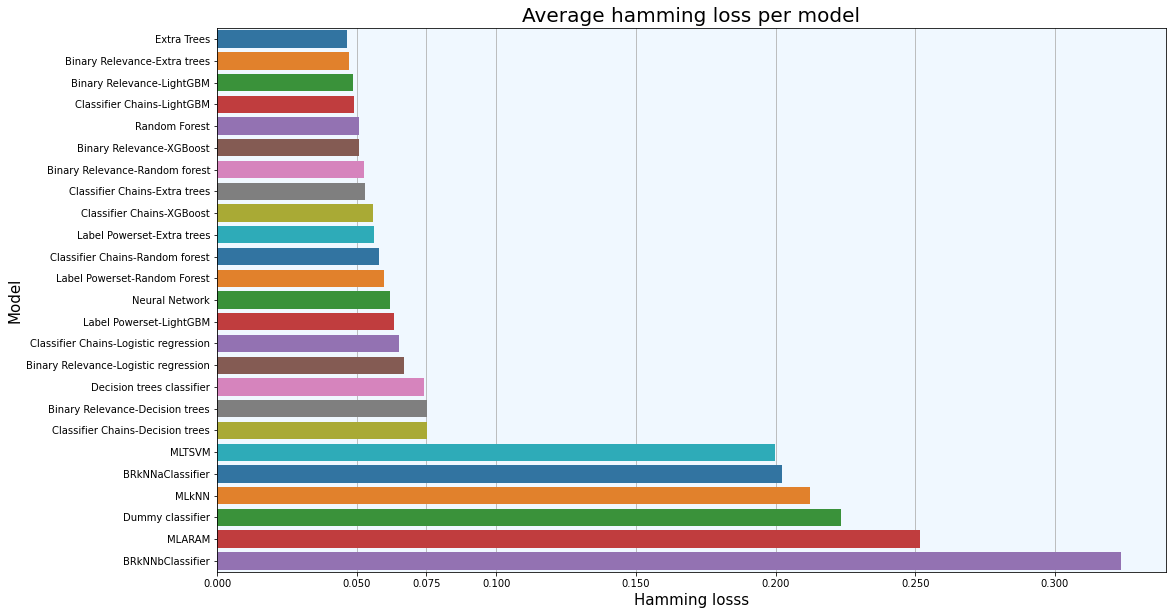

In [6]:
fig_dims = (17, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=list(hamming_loss.keys()), x=list(hamming_loss.values()), palette='tab10',)
plt.title('Average hamming loss per model', fontdict ={'size': 20})
plt.ylabel('Model', fontdict ={'size': 15})
plt.xlabel('Hamming losss',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xticks([0, 0.05, 0.075,0.1,0.15,0.2, 0.25, 0.3])
ax.set_axisbelow(True)
plt.grid(axis = 'x')
plt.show()